# Building an Agent

If you have followed our last session: All about prompt, and in the end, you have successfully build up a multi-turn travel agent with a prompt, then congratulations, you’ve already built a simple agent.
That “memory” that keeps your conversation coherent across multiple turns is one of the earliest signs of agency in AI systems.

In our previous sessions, we started with **direct LLM calls** — sending a prompt in, getting a response out. It’s quick, it’s powerful, but also… it forgets everything the moment the call ends. What if you want something smarter — a model that can reason over past messages, take actions, or use tools to solve problems for you?

That’s where **agents** come in.

Think of agents not as chatbots, but as **AI teammates** — digital coworkers who can:

- **Maintain context** across conversations,
- **Take on specialized roles**, and
- **Use tools or external functions** to accomplish complex tasks.

This combination transforms a one-shot LLM call into a continuous, reasoning-driven workflow.
In short: prompts make models respond; agents make models act.

The diagram below illustrates a typical AI agent structure at a high level:

<img alt="System Architecture" src="sources/ai_agent.png" width="600"/>

Before we start coding our own AI agent, let’s first import the required packages.

In [ ]:
from langchain_core.messages import HumanMessage, AIMessage

from automa_ai.agents.agent_factory import AgentFactory
from a2a.types import AgentSkill, AgentCard, AgentCapabilities
from automa_ai.agents import GenericAgentType, GenericLLM

## Building a chatbot
Our first agent is a chatbot. A chatbot can make conversation with a human. Let's first build up this chatbot's business card (agent card)

In [ ]:
skill = AgentSkill(
    id="eplus_assis",
    name="EnergyPlus Assistant",
    description="Provide explanation to EnergyPlus questions",
    tags=["assistant"],
    examples=["What does EnergyPlus do", "Where can we download EnergyPlus"],
)

# --8<-- [start:AgentCard]
# This will be the public-facing agent card
public_agent_card = AgentCard(
    name="Chat Bot Agent",
    description="An expert in building energy modeling and happy to have a chat with peers.",
    url="http://localhost:20000",
    version="1.0.0",
    default_input_modes=["text"],
    default_output_modes=["text"],
    capabilities=AgentCapabilities(streaming=True),
    skills=[skill],  # Only the basic skill for the public card
    supports_authenticated_extended_card=False,
)

chat_prompt = (f"You are an {public_agent_card.description} \n"
               f"Particularly, you are specialized in {public_agent_card.skills[0].description} \n"
               f"You may receive questions such as: 1. {public_agent_card.skills[0].examples[0]} or 2. {public_agent_card.skills[0].examples[0]}."
               "or just have a regular conversations with user but always emphasize your specialty at the end of your response."
               )


In [ ]:
chat_agent = AgentFactory(
    card=public_agent_card,
    instructions=chat_prompt,
    model_name="llama3.1:8b",
    agent_type=GenericAgentType.LANGGRAPH,
    chat_model=GenericLLM.OLLAMA,
)

In [ ]:
responses = await chat_agent.get_agent().invoke("What is the latest version of EnergyPlus?", "test_session_2")
for message in responses["messages"]:
    if isinstance(message, HumanMessage):
        print(f"User: {message.content} \n\n")
    elif isinstance(message, AIMessage):
        print(f"Assistant: {message.content} \n\n")

In [ ]:
responses = await chat_agent.get_agent().invoke("Trick you! The latest should be v25, which was released earlier this month", "test_session_1")
for message in responses["messages"]:
    if isinstance(message, HumanMessage):
        print(f"User: {message.content} \n\n")
    elif isinstance(message, AIMessage):
        print(f"Assistant: {message.content} \n\n")

How about build a chatbot that interact with an interface?

Typically, a user interface can be as simple as a command line interface (CLI), or a more user-friendly version, a rendered user interface - what can be better is running on a browser.

To run a chatbot

Based this class, we will first create an AI assistant that can have conversations with a human.

In [ ]:
class SimpleChatAgent(AgentBase):
    def __init__(self, model:str="llama3.1:8b"):
        super().__init__(model)

    def get_prompt_template(self) -> str:
        return (
            "You are a helpful, friendly AI assistant.\n"
            "Below is the chat history between you and the user.\n"
            "{history}\n"
            "AI:"
        )
    def invoke(self, user_input: str) -> str:
        """Run a conversation turn and return the model’s response."""
        # Append user input to history
        self.history += f"\nUser: {user_input}\n"
        # Truncate the history to 8000 characters
        self.history = clip_history(self.history, max_chars=8000)

        # Format prompt using subclass-defined template
        prompt_template = self.get_prompt_template()
        prompt = prompt_template.format(history=self.history)

        # Query the model
        response = self.llm.invoke([HumanMessage(content=prompt)])

        # Append AI reply to history
        self.history += f"{response.content}\n"

        return response.content

Done! Let's give our first AI assistant a try!

In [ ]:
agent = SimpleChatAgent()
print("Local Chat Agent (Llama3.1 via Ollama)\n")
while True:
    try:
        user_input = input("You: ")
        print(f"User: {user_input}\n")
        reply = agent.invoke(user_input)
        print(f"AI: {reply}\n")
    except KeyboardInterrupt:
        print("\nGoodbye!")
        break

## Building a tool agent
That was fun! now, we know not only the AI agent can make a conversation, it can also use tools. Curious how AI agent welding the tools? I do too. Let's dive in. But before that, let’s define a lightweight tool wrapper — similar in spirit to LangChain’s Tool, but simpler and easier to inspect.

In [ ]:
from typing import Callable
# A simplified Tool class based on LangChain's Tool implementation
class Tool:
    def __init__(self, name: str, description: str, func: Callable):
        self.name = name
        self.description = description
        self.func = func

    def run(self, *args, **kwargs):
        return self.func(*args, **kwargs)

This Tool class simply wrap around a python function, and its run function calls the tool to execute.
Now, based on our previous agentBase class, let's create a new agent.

In [ ]:
import json
from typing import Dict

class ToolAgent(AgentBase):
    def __init__(self, model:str="llama3.1:8b", tools: Dict[str, Tool]={}):
        super().__init__(model)
        self.tools = tools

    def register_tool(self, tool: Tool):
        self.tools[tool.name] = tool

    def get_prompt_template(self) -> str:
        """Default template for reasoning + tool use"""
        tool_descs = "\n".join(
            [f"{t.name}: {t.description}" for t in self.tools.values()]
        )
        return (
            "You are a smart assistant that can use tools to answer questions.\n"
            "Available tools:\n"
            f"{tool_descs}\n\n"
            "When needed, respond in JSON as:\n"
            '{{"action": "tool_name", "input": "..."}}\n'
            "Otherwise, reply normally.\n\n"
            "{history}\nAI:"
        )


    def invoke(self, user_input: str) -> str:
        """Enhanced invoke with tool detection"""
        self.history += f"\nUser: {user_input}\n"
        self.history = clip_history(self.history, 8000)

        prompt = self.get_prompt_template().format(history=self.history)
        print(f"-------------------- LLM prompt for tool call: \n\n {prompt}")
        response = self.llm.invoke([HumanMessage(content=prompt)])
        content = response.content.strip()

        # Try to parse tool request
        # Tool call is formatted as: {"action": "tool_name", "input": "..."}
        if content.startswith("{"):
            try:
                print(f"AI is making a tool call: {content}")
                action = json.loads(content)
                tool_name = action.get("action")
                tool_input = action.get("input", "")

                if tool_name in self.tools:
                    # Call tool
                    result = self.tools[tool_name].run(tool_input)
                    print(f"AI used tool: {tool_name} with inputs: {tool_input}\nResult: {result}\n")
                    # Update history
                    self.history += f"AI used {tool_name}: {tool_input}\nResult: {result}\n"
                    # Follow up with result to continue the conversation
                    followup_prompt = (
                        f"{self.history}\nThe tool returned: {result}\n"
                        "Provide the answer and continue offer help."
                    )
                    followup = self.llm.invoke([HumanMessage(content=followup_prompt)])
                    # Update history
                    self.history += f"{followup.content}\n"
                    return followup.content
                else:
                    return f"Tool `{tool_name}` not found."

            except Exception as e:
                return f"Error parsing tool action: {e}\n\nRaw model output:\n{content}"

        # Otherwise, treat as a normal answer
        self.history += f"{content}\n"
        return content

Done! we have our tool agent created. Next step, let's make some tools

In [ ]:
def add_numbers(input_text: str):
    """Add number tool: adds two numbers given in 'a,b' format for example: '3, 4' -> 7"""
    a, b = map(float, input_text.split(","))
    return a + b

def lookup_capital(country: str):
    capitals = {"France": "Paris", "Spain": "Madrid", "Italy": "Rome"}
    return capitals.get(country.strip(), "Unknown")

# Create tools
add_numbers_tool = Tool("add_numbers", "Add two numbers separated by a comma", add_numbers)
lookup_capital_tool = Tool("lookup_capital", "Return the capital city of a given country", lookup_capital)

# can add tool when initialize the agent
agent = ToolAgent(tools={"add_numbers": add_numbers_tool})
# or add tool through registration
agent.register_tool(lookup_capital_tool)

In [ ]:
# Let's run the tool agent!
if __name__ == "__main__":
    print("Tool-Using Agent (Llama3.1 via Ollama)\n")
    while True:
        try:
            user_input = input("You: ")
            reply = agent.invoke(user_input)
            print(f"AI: {reply}\n")
        except KeyboardInterrupt:
            print("\nGoodbye!")
            break

## Concepts in Developing an Agent
### 1. Model Routing
It is useful to be able to quickly test and experiment with different language models without needing to learn multiple provider's SDKs. This is known as **model routing**.

In [ ]:
agent = SimpleChatAgent(model="gemma3:4b")
print("Local Chat Agent (Gemma3:4b via Ollama)\n")
while True:
    try:
        user_input = input("You: ")
        print(f"User: {user_input}\n")
        reply = agent.invoke(user_input)
        print(f"AI: {reply}\n")
    except KeyboardInterrupt:
        print("\nGoodbye!")
        break

### 2. Structured output
When you use LLMs as part of an application, you often want them to return data in JSON format instead of unstructured text.

In [ ]:
# Build a Json output chain
class SimpleJsonOutputAgent(AgentBase):
    def __init__(self, model:str="llama3.1:8b"):
        super().__init__(model)

    def get_prompt_template(self) -> str:
        return ("You are a helpful, friendly AI assistant. You convert user information into a JSON object. Your response should always follow the format:\n"
                '{{"history": <history>, "user_query": "<user_query>", "timestamp": "<formatted in ISO format>"}}\n'
                "user query: {user_input}"
                "history: {history}")

    def invoke(self, user_input: str) -> str:
        """Run a conversation turn and return the model’s response."""
        # Append user input to history
        self.history += f"\nUser: {user_input}\n"
        # Truncate the history to 8000 characters
        self.history = clip_history(self.history, max_chars=8000)

        # Format prompt using subclass-defined template
        prompt_template = self.get_prompt_template()
        prompt = PromptTemplate.from_template(prompt_template)

        # Query the model
        # User Json Output Parser()
        llm_chain = prompt | self.llm | JsonOutputParser()
        response = llm_chain.invoke({"history": self.history, "user_input": user_input})
        # Append AI reply to history
        self.history += f"AI generated json: {response}\n"

        return response

In [ ]:
agent = SimpleJsonOutputAgent()
print("Local Output Agent (Llama3.1 via Ollama)\n")
user_input = input("You: ")
reply = agent.invoke(user_input)
print(reply)

LLMs are very powerful for processing unstructred or semi-structured text. Consider passing in the text of resumes and extracting a list of jobs, employers, and date ranges, or passing in a medical record and extracting a list of symptoms.

# 🧭 Agent Autonomy: From Chatbots to Autonomous Reasoners

Like self-driving vehicles, intelligent agents operate across a **spectrum of autonomy**.
Each level introduces more capability and decision-making freedom.

---

## ⚙️ Levels of Autonomy

There are many overlapping definitions of “agents” and “agency” in today’s ecosystem.
We’ll treat agency as a **spectrum of autonomy**, progressing through three major levels.

---

## 🧩 Level 1 – Chatbots & Routers

### 🧠 Core Capability
Agents at this level **produce text** or **route user inputs** based on predefined logic.
They are purely reactive — no tool use, no planning.

### 🚗 Analogy
A “Level 1” agent is like a **GPS navigator** — it tells you where to go but doesn’t drive the car. There is no impact to the real world, and human has the full control over the agent.

### 🧱 Example Implementation
Our SimpleChatAgent is the perfect example for such agent.
```python
class SimpleChatAgent(AgentBase):
    def get_prompt_template(self) -> str:
        return (
            "You are a helpful, friendly assistant.\n"
            "{history}\n"
            "AI:"
        )
```

### 💬 Behavior
- Responds directly to user input
- Cannot execute tools or change the environment
- Deterministic, safe, and fully human-in-the-loop

### 🔧 Common Uses
- Customer support bots
- Knowledge retrieval chat
- Routers to specialized agents

---

## 🛠️ Level 2 – Tool-Using Agents

### 🧠 Core Capability
The agent can act on the world via tool calls — using APIs, functions, or utilities.
This level marks the transition from “chatbot” to “actor.”

### 🚗 Analogy
A “Level 2” agent is like a driver-assist system — it performs limited actions automatically, under supervision.

### 🧱 Example Implementation
Our tool agent is a perfect example for this type of agent.
```python
agent = ToolAgentBase()
agent.register_tool(Tool("add_numbers", "Add two numbers", add_numbers_tool))
```
### 💬 Behavior
- Understands task context
- Can invoke tools via structured reasoning (```{"action": "...", "input": "..."}```)
- Has short-term memory and context clipping (clip_history)
- Still mostly reactive (one step at a time)

### 🔧 Common Uses
- Code execution or evaluation agents
- API orchestration (search, summarize, fetch)
- Assistants that interface with external data or services

---

## 🧠 Level 3 – Reasoning, Planning, and Tool Calls

### 🧠 Core Capability

The agent can plan, decompose goals, schedule subtasks, and act iteratively until objectives are achieved.

### 🚗 Analogy

A “Level 3” agent is like autonomous highway driving — it can plan and act with minimal human direction.

### 🧱 Example Implementation (Conceptual Preview)
```python
class PlannerAgent(ToolAgentBase):
    def invoke(self, user_input: str) -> str:
        # Step 1: Analyze goal
        goal_prompt = (
            f"User goal: {user_input}\n"
            "Break this goal into a list of ordered subtasks."
        )
        plan = self.llm.invoke([HumanMessage(content=goal_prompt)]).content

        # Step 2: Execute subtasks iteratively
        for task in parse_tasks(plan):
            print(f"Running subtask: {task}")
            result = super().invoke(task)
            self.history += f"\nSubtask result: {result}"

        return f"Plan complete. Summary:\n{result}"
```

### 💬 Behavior
- Generates plans instead of direct answers
- Executes multi-step reasoning loops
- Maintains a task queue or workflow graph
- Uses tools and memory autonomously

### 🔧 Common Uses
- Research agents
- Workflow orchestration (ReAct, LangGraph, or custom planners)
- Multi-tool reasoning (e.g., simulation, compliance checking, or review workflows)
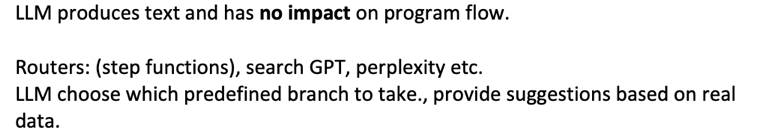
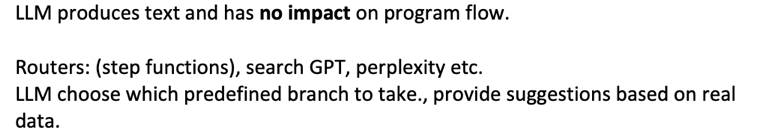

So far, we’ve built agents that **Level 1** and **Level 2**, how to build **Level 3**?

To move beyond simple tool use, an agent must not only call functions but also **reason about what to do next**, decide **which tools to use**, and **interpret intermediate results**.
This is the bridge to **Level 3 autonomy** — where reasoning and action are combined into a coherent loop.

---

## 🧠 Introducing the ReAct Framework

The **ReAct** paradigm, proposed by Yao et al. (2022) in the paper
**"[ReAct: Synergizing Reasoning and Acting in Language Models](https://arxiv.org/abs/2210.03629)"**,
showed that large language models perform better when they **interleave reasoning traces (“Thoughts”) and actions**.

Instead of producing a single response, a ReAct agent follows this general loop:

1. **Thought** – reason about the current situation
2. **Action** – choose and execute a tool or API call
3. **Observation** – observe the result
4. **Repeat** – continue reasoning with new context until a final answer is reached

<img alt="ReAct Agent Architecture" src="sources/react.png" width="600"/>

This structure allows the model to plan, execute, and adjust — enabling true *autonomy* in problem-solving.


In [ ]:
# Define a simple tool
@tool
def multiply(a: float, b: float) -> float:
    """Multiply two numbers."""
    return a * b

@tool
def division(a:float, b:float) -> float:
    """Divide two numbers"""
    return a / b

@tool
def addition(a:float, b:float) -> float:
    "Add two numbers."
    return a + b

@tool
def minus(a:float, b:float) -> float:
    "Subtract a from b."
    return a - b

In [ ]:
# Initialize the LLM (Ollama with Llama 3.1 | Qwen3:4b | Mistral:7b)
llm = ChatOllama(model="qwen3:4b", temperature=0.1)

# Create the ReAct agent using LangGraph’s prebuilt function
react_agent = create_react_agent(
    llm,
    tools=[multiply, division, addition, minus],
)

In [ ]:
# 1.5 miles / 2 hours = 0.75 miles/hour
question="Sammy hiked uphill 1.5 miles in 2 hours, Assume Sammy hiked at the same speed the entire time. How fast did Sammy hike in miles per hour?"

inputs = {"messages": [("user", {f"Question: {question} Use the provided tools for ALL mathematical operations and observe their outcome and provide the final answer."})]}
config = {"configurable": {"thread_id": 12345}}
# Run the agent with a reasoning + action task
for event in react_agent.stream(inputs, config, stream_mode="messages"):
    # Each event yields a tuple: (message, check_point)
    message, check_point = event
    if isinstance(message, AIMessage):
        if message.tool_calls:
            print(f"Action: {message.tool_calls[-1]["name"]}")
            print(f"Action Input: {message.tool_calls[-1]['args']}")
        elif message.content:
            print(message.content, end='')
    if isinstance(message, ToolMessage):
        if message.content:
            print(f"Observed value: {message.content}")

## Agent Memory

Memory is crucial for creating agents that maintain meaningful, contextual conversations over time.
While LLMs can process individual messages effectively, they need help managing longer-term context and historical interactions.

In our previous demo, we used a parameter called `history` to store all conversations and applied the `clip_history` function to limit its total character length.
That is probably the simplest form of memory management.

In real development, agents often use **hierarchical memory**.
Hierarchical memory is a structured approach that combines recent context with selectively retrieved long-term knowledge — much like how humans remember both what just happened and what they’ve learned before.


---

#### 🧠 Types of Hierarchical Memories

##### 1. Short-Term Memory
Short-term memory stores the **most recent exchanges** between the user and the agent — usually the last few messages or the clipped conversation window.
It allows the agent to stay coherent within a single interaction or session.
This is typically implemented as a rolling buffer, queue, or window of chat history.

> Example: The last 10 user–AI turns in an ongoing design review conversation.

---

##### 2. Long-Term Memory
Long-term memory retains **important information across sessions** — things the agent should remember persistently.
This could include user preferences, completed tasks, or facts extracted from earlier sessions.
In implementation, long-term memory is often stored in a vector database or key-value store and recalled when relevant (We will cover this part in the RAG session).

> Example: Remembering a user’s favorite modeling workflow or preferred code style weeks later.


---

##### 3. Semantic Memory
Semantic memory represents **general world knowledge** or **conceptual understanding** the agent has built up from prior experience.
It’s not tied to a specific conversation, but helps the agent reason and generalize.
For example, by embedding conversation fragments into vectors, an agent can retrieve semantically related information to enrich its reasoning.

> Example: Knowing that “insulation level” relates to “thermal resistance” when discussing wall design.


##### 4. Episodic Memory
Episodic memory captures **chronological event logs** — full records of past interactions or “episodes.”
This helps the agent reflect on what happened before, recognize progress, and learn from past mistakes.
Unlike long-term memory (which stores distilled knowledge), episodic memory stores **experiences** in sequence.

> Example: Keeping a detailed record of prior design review cycles, including decisions and revisions.

---

Together, these memory layers form a hierarchy:
- **Short-term memory** handles immediate conversation context.
- **Long-term and semantic memory** provide continuity and meaning.
- **Episodic memory** allows reflection and time-aware reasoning.

This combination enables agents to think more coherently across time — the foundation for adaptive, context-rich intelligence.


In [ ]:
from langgraph.checkpoint.memory import MemorySaver

# Create a memory checkpoint store
memory = MemorySaver()

memory_llm = ChatOllama(model="llama3.1:8b", temperature=0.1)

# Initialize LLM and ReAct agent
agent = create_react_agent(memory_llm, tools=[], checkpointer=memory)

# --- First turn
user_input = "I’m designing an office building in Seattle."
print(f"User: {user_input}")
input1 = {"messages": [{"role": "user", "content": user_input}]}
thread_id = "demo-session"

response1 = agent.invoke(input1, config={"configurable": {"thread_id": thread_id}})
print(f"AI response: {response1["messages"][-1].content}")
print("---------------------------------------------------------------")
# --- Second turn: Agent should recall context from checkpoint
user_input = "What city did I say my project is in?"
print(f"User: {user_input}")
input2 = {"messages": [{"role": "user", "content": user_input}]}
response2 = agent.invoke(input2, config={"configurable": {"thread_id": thread_id}})
print(f"AI response: {response2["messages"][-1].content}")

The above code example demonstrates the use of `MemorySaver` in the LangGraph agent's `check_pointer` to perform episode and short-term memories. Long-term and semantic memories relies on RAG system, which will be covered in later sessions.

## More on Agent Development

### Agent Middleware

When building production-grade agents, functionality alone isn’t enough. Middleware provides a way to manage everything that happens *around* the agent’s core reasoning — logging, monitoring, guardrails, authentication, or performance tracking. These layers ensure that your agent operates safely, securely, and reliably at scale.

---

#### 🧱 Guardrails

Guardrails refer broadly to mechanisms that **sanitize inputs and outputs** to prevent harmful, unsafe, or manipulative behavior.

- **Input sanitization** protects your model from *prompt injection attacks* — attempts to trick the model into revealing secrets, executing unsafe actions, or altering behavior.
- **Output sanitization** ensures that responses are factual, safe, and appropriate for end users.

In practice, guardrails may include:
- Pattern-based or semantic content filters.
- Role-based enforcement (e.g., preventing agents from accessing tools they shouldn't).
- Human-in-the-loop validation for high-stakes decisions.

Fortunately, newer model architectures (such as GPT-4, Claude 3, and Llama 3.1) have significantly improved built-in safety and alignment capabilities, but **external guardrails remain essential** in enterprise and regulated environments.

---

#### 🔐 Agent Authentication and Authorization

Two complementary permission layers govern secure agent operation:

1. **Resource-level authorization** — defines which data, APIs, or tools the agent can access.
   For instance, a design-review agent may have permission to read project data but not modify compliance records.

2. **User-level authentication** — defines which *users* or *other agents* can access or invoke this agent.
   This ensures that only authorized individuals or systems can trigger actions, query private data, or chain multiple agents.

These topics are still evolving rapidly. Standards such as **A2A (Agent-to-Agent protocol)** are emerging to formalize secure authentication, authorization, and inter-agent communication — much like OAuth did for traditional web services.

---

> In short, middleware is what transforms an experimental LLM script into a **trusted, production-ready agent**.
> It keeps the agent safe, compliant, and auditable — ready to operate as part of a larger system of intelligent components.